# Road Damage YOLOv8 Train and Predict

In [2]:
!pip install wandb==0.15.0
!wandb --version

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.9 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.12.21
    Uninstalling wandb-0.12.21:
      Successfully uninstalled wandb-0.12.21
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.1 requires wandb<0.13.0,>=0.10.0, but you have wandb 0.15.0 which is incompatible.
wandb, version 0.15.0


In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.5/605.5 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60


In [4]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
from matplotlib import animation, rc
rc('animation', html='jshtml')
from PIL import Image
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

requirements: Ultralytics requirement ['py-cpuinfo'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 14.4s, installed 1 package: ['py-cpuinfo']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

Ultralytics YOLOv8.0.137 🚀 Python-3.7.12 torch-1.11.0+cpu CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 4959.0/8062.4 GB disk)


In [5]:
# Wandb login:
from kaggle_secrets import UserSecretsClient
import wandb
user_secrets = UserSecretsClient()
secret_value = user_secrets.get_secret("wandb_api_key")
wandb.login(key=secret_value)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
!mkdir datasets
!mkdir datasets/train
!mkdir datasets/valid
!mkdir datasets/test

train_path='datasets/train/'
valid_path='datasets/valid/'
test_path='datasets/test/'

# Data Preparation

In [7]:
ano_paths=[]
i=0
for dirname, _, filenames in os.walk('/kaggle/input/road-damage-tracking-dataset-rdtd-v10/train-pure/train-pure/labels'):
    for filename in filenames:
        if filename[-4:]=='.txt' and i<400:
            ano_paths+=[(os.path.join(dirname, filename))]
            i+=1
        
n=len(ano_paths) 
print(n)
N=list(range(n))
random.shuffle(N)

train_ratio = 0.6
valid_ratio = 0.2
test_ratio = 0.2

train_size = int(train_ratio*n)
valid_size = int(valid_ratio*n)

train_i = N[:train_size]
valid_i = N[train_size:train_size+valid_size]
test_i = N[train_size+valid_size:]

#print(train_i)
#print(valid_i)
#print(test_i)

400


In [8]:
for i in train_i:
    ano_path=ano_paths[i]
    img_path=os.path.join('/kaggle/input/road-damage-tracking-dataset-rdtd-v10/train-pure/train-pure/images',
                          ano_path.split('/')[-1][0:-4]+'.jpg')
    try:
        !cp {ano_path} {train_path}
        !cp {img_path} {train_path}
    except:
        continue
print(len(os.listdir(train_path)))

480


In [9]:
for i in valid_i:
    ano_path=ano_paths[i]
    img_path=os.path.join('/kaggle/input/road-damage-tracking-dataset-rdtd-v10/train-pure/train-pure/images',
                          ano_path.split('/')[-1][0:-4]+'.jpg')
    try:
        !cp {ano_path} {valid_path}
        !cp {img_path} {valid_path}
    except:
        continue
print(len(os.listdir(valid_path)))

160


In [10]:
for i in test_i:
    ano_path=ano_paths[i]
    img_path=os.path.join('/kaggle/input/road-damage-tracking-dataset-rdtd-v10/train-pure/train-pure/images',
                          ano_path.split('/')[-1][0:-4]+'.jpg')
    try:
        !cp {ano_path} {test_path}
        !cp {img_path} {test_path}
    except:
        continue
print(len(os.listdir(test_path)))      

160


# Create yaml file 

In [11]:
import yaml

data_yaml = dict(
    train ='train',
    val ='valid',
    test='test',
    nc =1,
    names =['damage']
)

with open('data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)
    
%cat data.yaml

{names: [damage], nc: 1, test: test, train: train, val: valid}


In [12]:
names =['damage']
M=list(range(len(names)))
class_map=dict(zip(M,names))

# Train

In [13]:
model = YOLO("yolov8x.pt") 

  0%|          | 0.00/131M [00:00<?, ?B/s]

In [14]:
!yolo task=detect mode=train model=yolov8x.pt data=data.yaml epochs=12 imgsz=480

Ultralytics YOLOv8.0.137 🚀 Python-3.7.12 torch-1.11.0+cpu CPU (Intel Xeon 2.20GHz)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=data.yaml, epochs=12, patience=50, batch=16, imgsz=480, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False

# Result of Training

In [15]:
paths2=[]
for dirname, _, filenames in os.walk('/kaggle/working/runs/detect/train'):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            paths2+=[(os.path.join(dirname, filename))]
paths2=sorted(paths2)

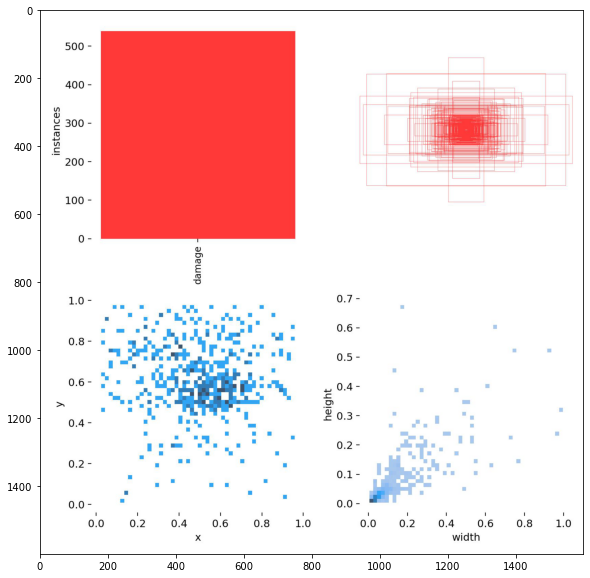

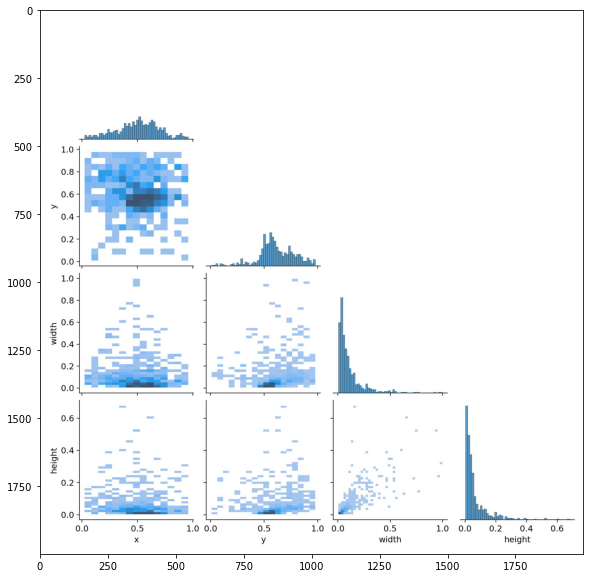

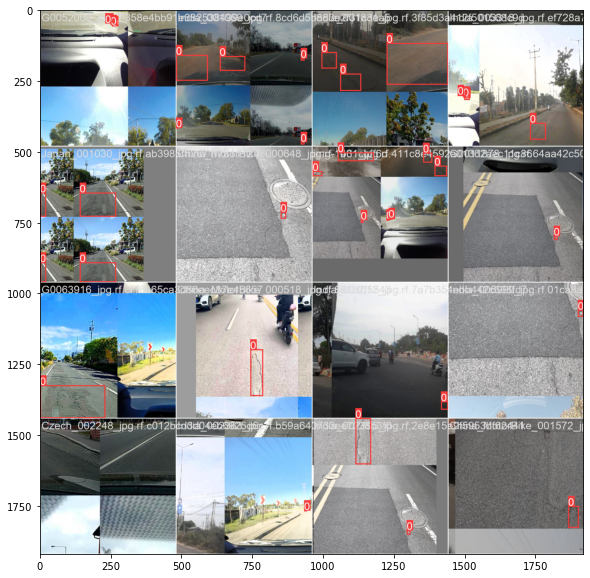

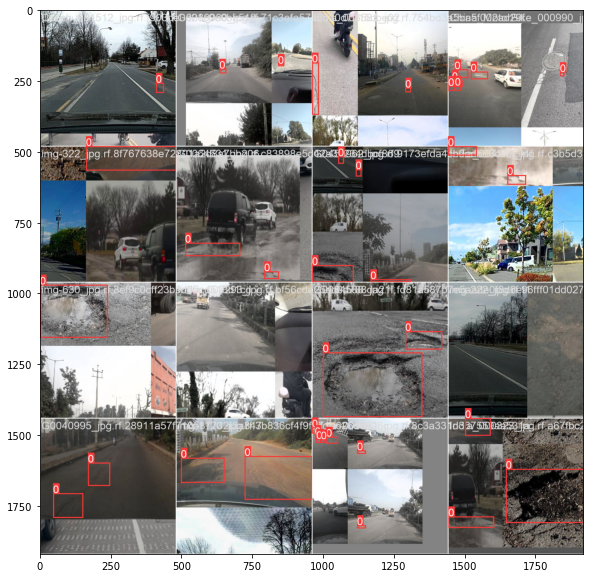

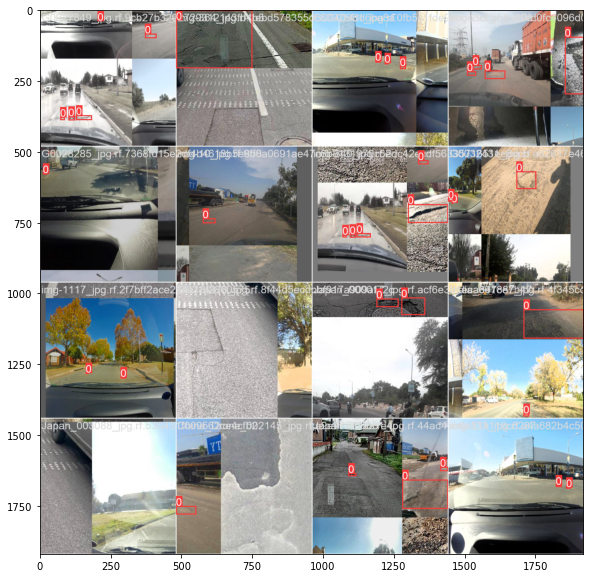

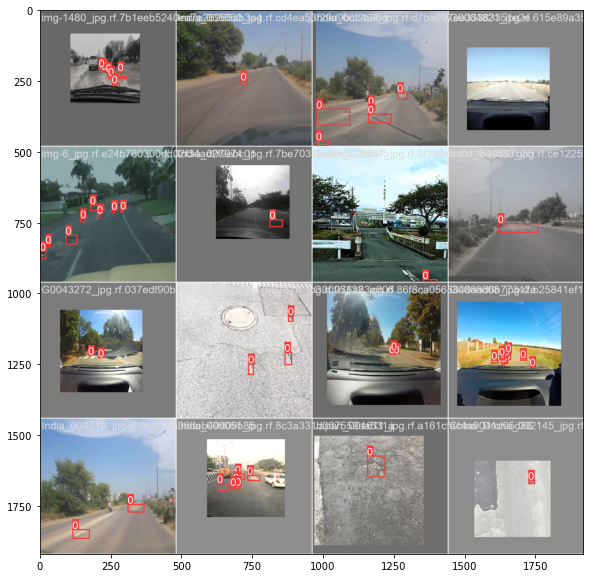

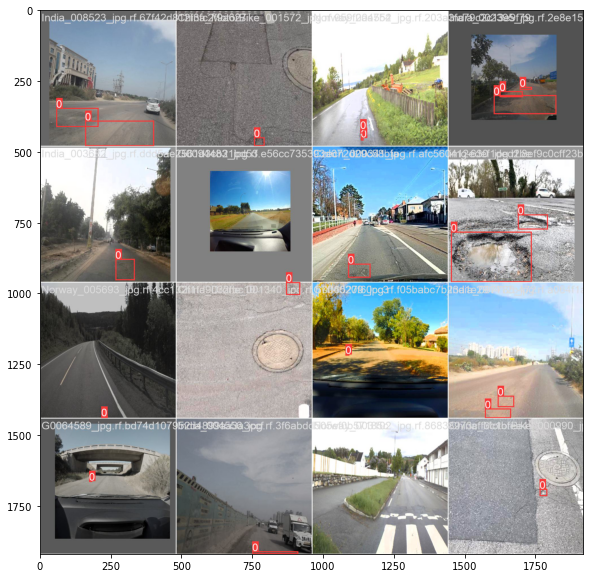

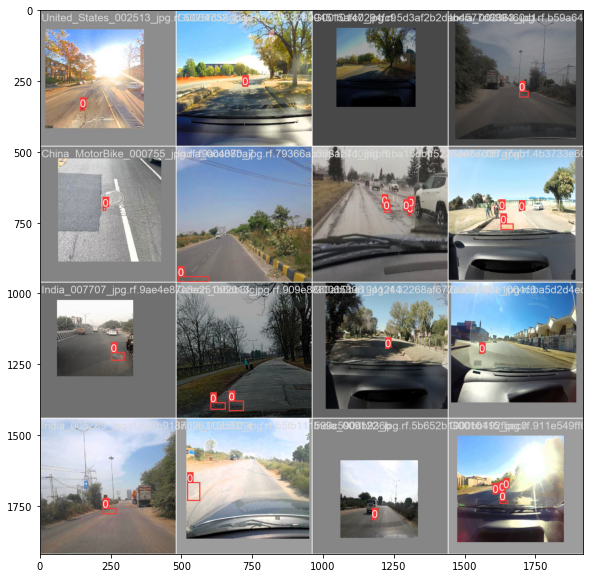

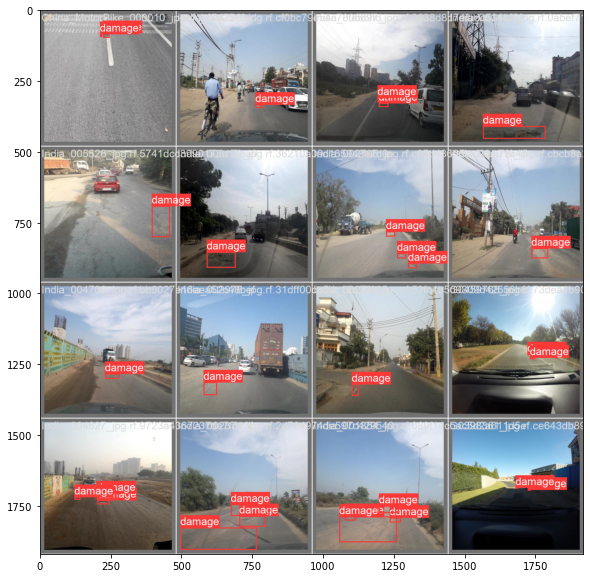

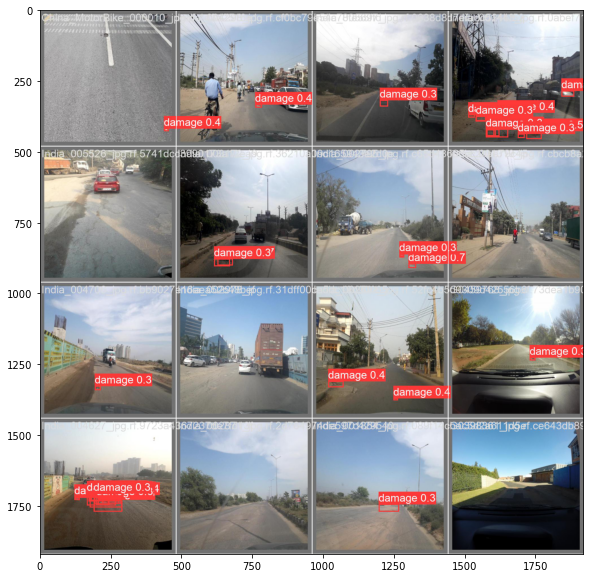

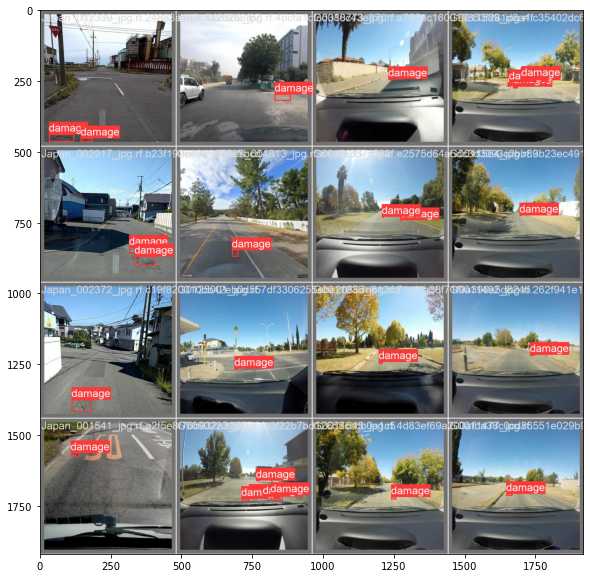

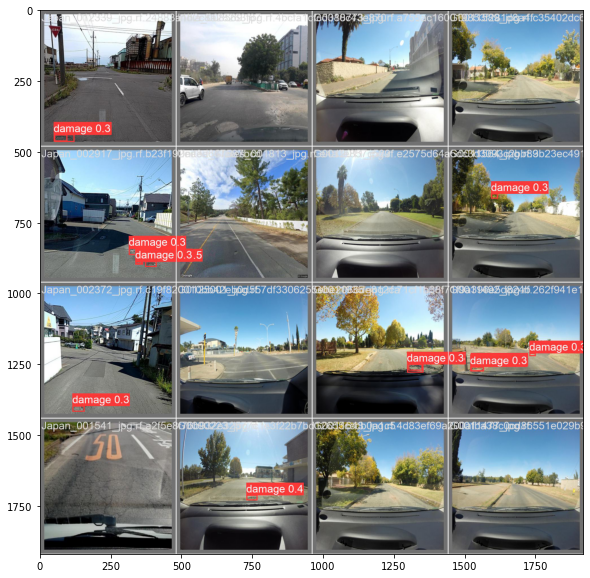

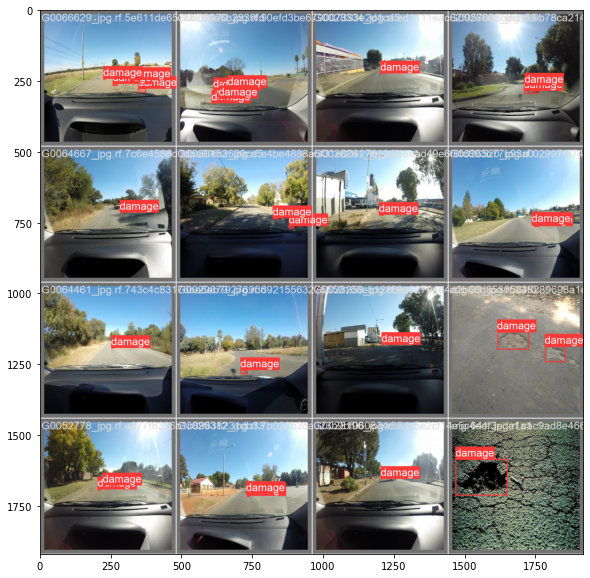

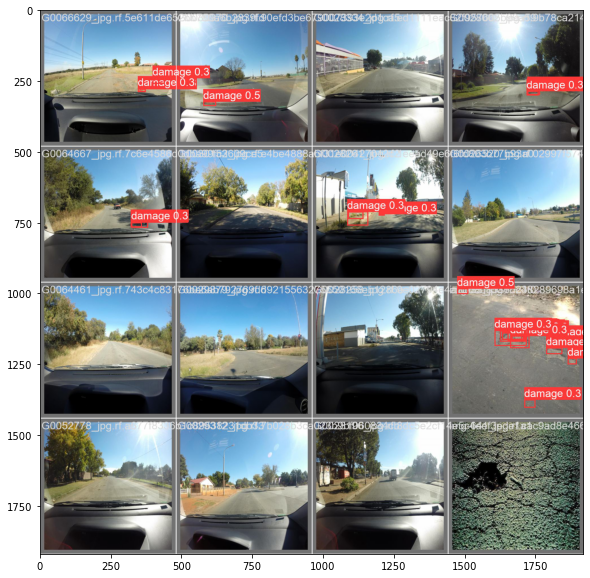

In [16]:
for path in paths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(20,10))
    plt.imshow(image)
    plt.show()

# Predict

In [17]:
best_path0='runs/detect/train/weights/best.pt'
source0='datasets/test'

In [18]:
ppaths=[]
for dirname, _, filenames in os.walk(source0):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            ppaths+=[(os.path.join(dirname, filename))]
ppaths=sorted(ppaths)
print(ppaths[0])
print(len(ppaths))

datasets/test/China_MotorBike_000786_jpg.rf.0973641e67a8933f92465b13f7a2a9f5.jpg
80


In [19]:
model2 = YOLO(best_path0)

In [20]:
!yolo task=detect mode=predict model={best_path0} conf=0.1 source={source0}

Ultralytics YOLOv8.0.137 🚀 Python-3.7.12 torch-1.11.0+cpu CPU (Intel Xeon 2.20GHz)
Model summary (fused): 268 layers, 68124531 parameters, 0 gradients

image 1/80 /kaggle/working/datasets/test/China_MotorBike_000786_jpg.rf.0973641e67a8933f92465b13f7a2a9f5.jpg: 480x480 3 damages, 2042.9ms
image 2/80 /kaggle/working/datasets/test/China_MotorBike_001002_jpg.rf.886650c3fa0028931a752766bea6a9a2.jpg: 480x480 2 damages, 1342.5ms
image 3/80 /kaggle/working/datasets/test/China_MotorBike_001084_jpg.rf.ce0112fa41a0a49701c3773bb51cca89.jpg: 480x480 5 damages, 1322.7ms
image 4/80 /kaggle/working/datasets/test/Czech_002444_jpg.rf.87f9558007f067986331f4958147744d.jpg: 480x480 1 damage, 1352.3ms
image 5/80 /kaggle/working/datasets/test/Czech_002448_jpg.rf.b7930696aaa3f111883f9ff541f26529.jpg: 480x480 7 damages, 1346.0ms
image 6/80 /kaggle/working/datasets/test/G0010120_jpg.rf.fd356eb48f69418cfbabc03e4ffc81c4.jpg: 480x480 6 damages, 1340.5ms
image 7/80 /kaggle/working/datasets/test/G0011496_jpg.rf.2007

# Result of Prediction

In [21]:
results = model2.predict(source0,conf=0.1)
print(len(results))


image 1/80 /kaggle/working/datasets/test/China_MotorBike_000786_jpg.rf.0973641e67a8933f92465b13f7a2a9f5.jpg: 480x480 3 damages, 1397.2ms
image 2/80 /kaggle/working/datasets/test/China_MotorBike_001002_jpg.rf.886650c3fa0028931a752766bea6a9a2.jpg: 480x480 2 damages, 1403.9ms
image 3/80 /kaggle/working/datasets/test/China_MotorBike_001084_jpg.rf.ce0112fa41a0a49701c3773bb51cca89.jpg: 480x480 5 damages, 1406.3ms
image 4/80 /kaggle/working/datasets/test/Czech_002444_jpg.rf.87f9558007f067986331f4958147744d.jpg: 480x480 1 damage, 1391.7ms
image 5/80 /kaggle/working/datasets/test/Czech_002448_jpg.rf.b7930696aaa3f111883f9ff541f26529.jpg: 480x480 7 damages, 1974.5ms
image 6/80 /kaggle/working/datasets/test/G0010120_jpg.rf.fd356eb48f69418cfbabc03e4ffc81c4.jpg: 480x480 6 damages, 1448.1ms
image 7/80 /kaggle/working/datasets/test/G0011496_jpg.rf.2007c8144b3af55b64b5358afd69e170.jpg: 480x480 14 damages, 1366.3ms
image 8/80 /kaggle/working/datasets/test/G0020198_jpg.rf.0058c06b575627a772a2a4d7ac0e837

80


In [22]:
print((results[0].boxes.data))

tensor([[1.0748e+03, 1.1956e+03, 1.1894e+03, 1.2748e+03, 3.2739e-01, 0.0000e+00],
        [4.9919e+02, 6.1855e+02, 5.6719e+02, 6.5482e+02, 1.4209e-01, 0.0000e+00],
        [1.0754e+03, 1.1913e+03, 1.1752e+03, 1.2622e+03, 1.0574e-01, 0.0000e+00]])


In [23]:
PBOX=pd.DataFrame(columns=range(6))
for i in range(len(results)):
    arri=pd.DataFrame(results[i].boxes.data.cpu().numpy()).astype(float)
    path=ppaths[i]
    file=path.split('/')[-1]
    arri=arri.assign(file=file)
    arri=arri.assign(i=i)
    PBOX=pd.concat([PBOX,arri],axis=0)
PBOX.columns=['x','y','x2','y2','confidence','class','file','i']
display(PBOX)

x            y           x2           y2  confidence  class  \
0   1074.830688  1195.629517  1189.384399  1274.793335    0.327385    0.0   
1    499.194672   618.548889   567.187500   654.823975    0.142092    0.0   
2   1075.423462  1191.280762  1175.215576  1262.181519    0.105742    0.0   
0   1180.977051  1144.740356  1226.686035  1168.699097    0.251190    0.0   
1   1132.213989    87.545235  1250.383667   129.776291    0.115324    0.0   
..          ...          ...          ...          ...         ...    ...   
9    897.803406   591.357361  1012.402832   660.730896    0.118001    0.0   
10   889.778137   581.904114  1085.961060   737.725891    0.107818    0.0   
0   1005.162903   430.977692  1099.149902   479.178223    0.174704    0.0   
1   1041.043091   449.820160  1096.952026   472.018402    0.144499    0.0   
2    979.073059   422.618286  1097.197754   479.505096    0.141684    0.0   

                                                 file     i  
0   China_MotorBike_000786_jpg.rf.0973641e67a8933f...   0.0  
1   China_MotorBike_000786_jpg.rf.0973641e67a8933f...   0.0  
2   China_MotorBike_000786_jpg.rf.0973641e67a8933f...   0.0  
0   China_MotorBike_001002_jpg.rf.886650c3fa002893...   1.0  
1   China_MotorBike_001002_jpg.rf.886650c3fa002893...   1.0  
..                                                ...   ...  
9   img-658_jpg.rf.b6ddfbd32b5bf441069a6cf965cacb1...  78.0  
10  img-658_jpg.rf.b6ddfbd32b5bf441069a6cf965cacb1...  78.0  
0   img-959_jpg.rf.20282c4f6b1b43126e7db4a4eb2e521...  79.0  
1   img-959_jpg.rf.20282c4f6b1b43126e7db4a4eb2e521...  79.0  
2   img-959_jpg.rf.20282c4f6b1b43126e7db4a4eb2e521...  79.0  

[567 rows x 8 columns]

In [24]:
PBOX['class']=PBOX['class'].apply(lambda x: class_map[int(x)])
PBOX=PBOX.reset_index(drop=True)
display(PBOX)
display(PBOX['class'].value_counts())

x            y           x2           y2  confidence   class  \
0    1074.830688  1195.629517  1189.384399  1274.793335    0.327385  damage   
1     499.194672   618.548889   567.187500   654.823975    0.142092  damage   
2    1075.423462  1191.280762  1175.215576  1262.181519    0.105742  damage   
3    1180.977051  1144.740356  1226.686035  1168.699097    0.251190  damage   
4    1132.213989    87.545235  1250.383667   129.776291    0.115324  damage   
..           ...          ...          ...          ...         ...     ...   
562   897.803406   591.357361  1012.402832   660.730896    0.118001  damage   
563   889.778137   581.904114  1085.961060   737.725891    0.107818  damage   
564  1005.162903   430.977692  1099.149902   479.178223    0.174704  damage   
565  1041.043091   449.820160  1096.952026   472.018402    0.144499  damage   
566   979.073059   422.618286  1097.197754   479.505096    0.141684  damage   

                                                  file     i  
0    China_MotorBike_000786_jpg.rf.0973641e67a8933f...   0.0  
1    China_MotorBike_000786_jpg.rf.0973641e67a8933f...   0.0  
2    China_MotorBike_000786_jpg.rf.0973641e67a8933f...   0.0  
3    China_MotorBike_001002_jpg.rf.886650c3fa002893...   1.0  
4    China_MotorBike_001002_jpg.rf.886650c3fa002893...   1.0  
..                                                 ...   ...  
562  img-658_jpg.rf.b6ddfbd32b5bf441069a6cf965cacb1...  78.0  
563  img-658_jpg.rf.b6ddfbd32b5bf441069a6cf965cacb1...  78.0  
564  img-959_jpg.rf.20282c4f6b1b43126e7db4a4eb2e521...  79.0  
565  img-959_jpg.rf.20282c4f6b1b43126e7db4a4eb2e521...  79.0  
566  img-959_jpg.rf.20282c4f6b1b43126e7db4a4eb2e521...  79.0  

[567 rows x 8 columns]

damage    567
Name: class, dtype: int64